In [3]:
from matplotlib import patches
from matplotlib import rcParams
from scipy import stats
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, setdiff, join, unique
from photutils import detect_sources, deblend_sources
from photutils import CircularAperture, CircularAnnulus


from utils import *

rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'font.serif': 'Times New Roman'})


mu: 884.42 , std: 4.96 , ZP: 27.10 , pix_scale: 2.50


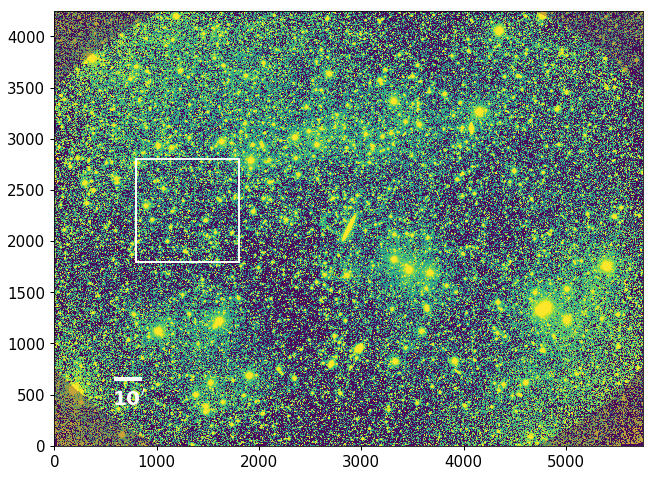

In [6]:
############################################
# Read 
############################################

hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

seeing = 2.5
# Runned from create_photometric_light_APASS 
seg_map = fits.open("./SE_APASS/coadd_SloanR_NGC_5907_seg.fits")[0].data
weight_edge = fits.open("./weight_NGC5907.fits")[0].data
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor")

mu, std = np.float(hdu.header["BACKVAL"]), mad_std(hdu.data[seg_map==0&(weight_edge>0.5)]) 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

############################################
# Crop
############################################
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 1800, 1800, 2800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 600, 1800, 1600)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3100, 1400, 4100, 2400)
image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
        
patch, seg_patch = crop_image(data, seg_map, image_bounds, weight_map=weight_edge, 
                              sky_mean=mu, sky_std=std, color="w",draw=True)

In [7]:
############################################
# Crossmatch
############################################

def transform_coords2pixel(tab, cat_name, w=wcs_data, RA_key="RAJ2000", DE_key="DEJ2000"):
    coords = np.vstack([np.array(tab[RA_key]), 
                        np.array(tab[DE_key])]).T
    pos = w.wcs_world2pix(coords, 1)
    tab.add_column(Column(np.around(pos[:,0], 4)*u.pix), name='X_IMAGE'+'_'+cat_name)
    tab.add_column(Column(np.around(pos[:,1], 4)*u.pix), name='Y_IMAGE'+'_'+cat_name)
    tab.add_column(Column(np.arange(len(tab))+1), index=0, name="ID"+'_'+cat_name)
    return tab

result = query_vizier(catalog_name="URAT", radius=2*u.deg,
                      columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                      column_filters={'mfa':'=1', 'rmag':'{0} .. {1}'.format(8, 18)}, header=header)

Cat_URAT = result['I/329/urat1']
Cat_URAT = transform_coords2pixel(Cat_URAT, cat_name="URAT")     
print("URAT Brightest Star: %.3f"%Cat_URAT["rmag"].min())
    
result = query_vizier(catalog_name="USNO", radius=2*u.deg,
                      columns=['RAJ2000', 'DEJ2000', "Bmag","Rmag"],
                      column_filters={"Rmag":'{0} .. {1}'.format(5, 15)}, header=header)

Cat_USNO = result['I/252/out']
Cat_USNO = transform_coords2pixel(Cat_USNO, cat_name="USNO")
print("USNO Brightest Star: %.3f"%Cat_USNO["Rmag"].min())

############################################
# Merge Catalog
############################################

df_match_URAT = merge_catalog(SE_cat_full, Cat_URAT, sep=2.5*u.arcsec, 
                              keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO", 'FWHM_IMAGE',
                                            "ID_URAT","X_IMAGE_URAT","Y_IMAGE_URAT","rmag","gmag","FLAGS"])
df_match_USNO = merge_catalog(SE_cat_full, Cat_USNO, sep=5*u.arcsec,
                               keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO",
                                             "ID_USNO","X_IMAGE_USNO","Y_IMAGE_USNO","Rmag","FLAGS"])

df_SE_match_all = pd.merge(df_match_URAT, df_match_USNO, how='outer')

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)

target = df_SE_match["RMAG_AUTO"] < 15
df_SE_target = df_SE_match[target].sort_values("RMAG_AUTO")
df_SE_target

URAT Brightest Star: 10.021
USNO Brightest Star: 7.000


,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_URAT,gmag,rmag,X_IMAGE_URAT,Y_IMAGE_URAT,ID_USNO,Rmag,X_IMAGE_USNO,Y_IMAGE_USNO
439,13075,1922.5291,2790.8242,0.056,NaN,6,10.393505,NaN,NaN,NaN,NaN,NaN,2432.0,12.2,1921.3436,2791.4138
436,11019,1637.7390,2975.6692,0.079,NaN,6,10.593760,NaN,NaN,NaN,NaN,NaN,2650.0,8.5,1636.4046,2976.1362
440,13181,801.3793,2767.6765,0.164,NaN,4,10.823486,NaN,NaN,NaN,NaN,NaN,3249.0,9.1,799.8141,2767.2639
437,11384,1016.5814,2938.4541,0.113,NaN,7,10.868803,NaN,NaN,NaN,NaN,NaN,3121.0,9.1,1015.5628,2937.6401
449,17421,897.8304,2346.7397,0.097,NaN,4,10.892657,NaN,NaN,NaN,NaN,NaN,3175.0,9.0,897.5151,2347.2010
445,14749,610.3319,2612.9285,0.035,NaN,6,10.946736,NaN,NaN,NaN,NaN,NaN,3342.0,9.2,609.8641,2614.3060
438,11617,1149.5371,2915.1829,0.041,NaN,6,10.995135,NaN,NaN,NaN,NaN,NaN,3017.0,9.3,1148.5710,2915.3667
451,17958,1945.9363,2290.8757,0.136,NaN,6,11.236383,NaN,NaN,NaN,NaN,NaN,2411.0,9.6,1945.1266,2290.4196
17,11478,1939.9355,2943.9451,0.097,4.19,6,11.281835,3532.0,10.529000,10.036,1939.6365,2943.8519,2427.0,10.9,1939.1548,2943.3189
454,18886,1481.7998,2205.2131,0.027,NaN,4,11.310009,NaN,NaN,NaN,NaN,NaN,2777.0,9.8,1481.4996,2204.7364


In [498]:
df_SE_target[abs(df_SE_target["RMAG_AUTO"]-12.5)<0.1]

,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_URAT,gmag,rmag,X_IMAGE_URAT,Y_IMAGE_URAT,ID_USNO,Rmag,X_IMAGE_USNO,Y_IMAGE_USNO
126,19356,3138.2263,2163.9592,0.056,3.36,4,12.413796,2176.0,12.764,11.959,3138.1933,2163.8268,1481.0,12.1,3138.1875,2163.9332
63,17194,4123.9966,2368.3999,0.161,3.22,6,12.450636,4559.0,12.714,12.018,4124.1118,2368.3295,797.0,12.3,4124.1960,2368.4799
147,19989,3043.9800,2105.8062,0.010,3.18,7,12.473516,2174.0,12.377,12.050,3043.9827,2105.7017,1557.0,11.7,3043.9363,2105.8591
175,21401,3193.7654,1973.6454,0.014,3.10,4,12.474362,2170.0,12.538,12.051,3193.7561,1973.5024,1445.0,12.3,3193.5870,1973.3177


## Meausre Scaling

In [51]:
############################################
# Measure
############################################

def get_star_pos(id, star_cat, ref_pos=(0,0)):
    X_c, Y_c = star_cat[id]["X_IMAGE"]-ref_pos[0], star_cat[id]["Y_IMAGE"]-ref_pos[1]
    return (X_c, Y_c)

def get_star_thumb(id, star_cat, data=data, seg_map=seg_map, 
                   n_win=20, ref_pos=(0,0), seeing=2.5, w=wcs_data, verbose=True):
    (X_c, Y_c) = get_star_pos(id, star_cat, ref_pos=ref_pos)    
    
    fwhm =  max(star_cat[id]["FWHM_IMAGE"], seeing)
    win_size = int( n_win * min(max(fwhm,2), 8))
    
    X_min, X_max = X_c - win_size, X_c + win_size
    Y_min, Y_max = Y_c - win_size, Y_c + win_size
    x_min, y_min = coord_Im2Array(X_min, Y_min)
    x_max, y_max = coord_Im2Array(X_max, Y_max)
    
    if verbose:
        num = star_cat[id]["NUMBER"]
        print("NUMBER: ",num)
        print("X_c, Y_c: ", (X_c, Y_c))
        print("x_min, x_max, y_min, y_max: ", x_min, x_max, y_min, y_max)
    
    img_thumb = data[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max].copy()
    seg_thumb = seg_map[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max]
    mask_thumb = (seg_thumb!=0)    
    
    X_cen, Y_cen = w.wcs_world2pix(star_cat[id]["X_WORLD"], star_cat[id]["Y_WORLD"], 1)
    cen_star = X_cen - (y_min+1), Y_cen - (x_min+1)
    
    return img_thumb, seg_thumb, mask_thumb, cen_star
    
def extract_star(id, star_cat, data=data, seg_map=seg_map, 
                 seeing=2.5, sn_thre=2.5, n_win=20,
                 display_bg=False, display=True, verbose=False):
    
    img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data=data, seg_map=seg_map,
                                                                n_win=n_win, seeing=seeing, verbose=verbose)
    fwhm = max([star_cat[id]["FWHM_IMAGE"], seeing])

    b_size = round(img_thumb.shape[0]//5/25)*25
    if img_thumb.shape[0] > 50:
        back, back_rms = background_sub_SE(img_thumb, b_size=b_size)
    else:
        back, back_rms = (np.median(img_thumb[~mask_thumb])*np.ones_like(img_thumb), 
                            mad_std(img_thumb[~mask_thumb])*np.ones_like(img_thumb))
    if display_bg:
            display_background_sub(img_thumb, back)        
    # do segmentation (second time, target-based)
    sigma = seeing * gaussian_fwhm_to_sigma
    threshold = back + (sn_thre * back_rms)
    segm = detect_sources(img_thumb, threshold, npixels=5)
    
    # deblending
    segm_deblend = deblend_sources(img_thumb, segm, npixels=5,
                                   nlevels=64,
                                   contrast=0.005)
    star_lab = segm_deblend.data[img_thumb.shape[0]//2, img_thumb.shape[1]//2]
    star_ma = ~((segm_deblend.data==star_lab) | (segm_deblend.data==0)) # mask other source
    
    # display
    if display:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(21,5))
        ax1.imshow(img_thumb, vmin=np.median(back)-1, vmax=10000, norm=norm1, origin="lower", cmap="viridis")
        ax1.set_title("star", fontsize=15)
        ax2.imshow(segm, origin="lower", cmap=segm.make_cmap(random_state=12345))
        ax2.set_title("segment", fontsize=15)
        ax3.imshow(segm_deblend, origin="lower", cmap=segm_deblend.make_cmap(random_state=12345))
        ax3.set_title("deblend", fontsize=15)

        img_thumb_ma = img_thumb.copy()
        img_thumb_ma[star_ma] = -1
        ax4.imshow(img_thumb_ma, origin="lower", cmap="viridis", 
                   vmin=np.median(back)-1, vmax=np.median(back)+10*np.median(back_rms), norm=norm2)
        ax4.set_title("extracted star", fontsize=15)
    
    return img_thumb, star_ma, back, cen_star

def compute_Rnorm(image, mask_field, cen, R=8, wid=0.5, mask_cross=False, display=False):
    """ Return sigma-clipped mean, med and std of ring r=R (half-width=wid) for image"""
    annulus = CircularAnnulus(cen, R-wid, R+wid)
    annulus_ma = annulus.to_mask()      
    mask_ring = annulus_ma.to_image(image.shape)>0.5    # sky ring (R-wid, R+wid)
    
    mask_clean = mask_ring & (~mask_field)            # sky ring with other sources masked
    if mask_cross:
        yy, xx = np.indices(image.shape)
        rr = np.sqrt((xx-cen[0])**2+(yy-cen[1])**2)
        cross = ((abs(xx-cen[0])<1.)|(abs(yy-cen[1])<1.))
        mask_clean = mask_clean * (~cross)
        
    z_mean, z_med, z_std = sigma_clipped_stats(image[mask_clean], sigma=3)
    
    if display:
        fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(9,4))
        ax1.imshow(mask_clean*image, origin="lower", cmap="gray", norm=norm1, vmin=z_med-5*z_std, vmax=z_med+5*z_std)
        ax2 = plt.hist(sigma_clip(image[mask_clean]))
    
    return z_mean, z_med, z_std

def compute_Rnorm_batch(tab_SE_target, SE_catalog=SE_cat_full, R=8, wid=0.5, return_full=False):
    res_thumb = {}    
    res_Rnorm = np.empty((len(tab_SE_target),4))
    for i, (num, rmag_auto) in enumerate(zip(tab_SE_target['NUMBER'], tab_SE_target['RMAG_AUTO'])):
        process_counter(i, len(tab_SE_target))

        ind = num - 1
        n_win = 30 if rmag_auto< 11 else 20
            
        img, ma, bkg, cen = extract_star(ind, SE_cat_full, n_win=n_win, display_bg=False, display=False)
        
        res_thumb[num] = {"image":img, "mask":ma, "bkg":bkg, "center":cen}
        
        z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=R, wid=wid)
        sky_mean = np.median(bkg)
        res_Rnorm[i] = np.array([z_mean, z_med, z_std, sky_mean])
    return res_Rnorm, res_thumb

In [52]:
res_Rnorm, res_thumb = compute_Rnorm_batch(df_SE_target, SE_catalog=SE_cat_full, R=10, wid=0.5, return_full=True)

table_res_Rnorm = Table(np.hstack([df_SE_target['NUMBER'].values[:, None],
                                   df_SE_target['X_IMAGE'].values[:, None],
                                   df_SE_target['Y_IMAGE'].values[:, None], res_Rnorm]), 
                        names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)

completed: 43/217
completed: 86/217
completed: 129/217
completed: 172/217
completed: 215/217


In [53]:
table_res_Rnorm.write('Rnorm_10pix_15mag_X%sY%s.txt'%(patch_Xmin, patch_Ymin), overwrite=True, format='ascii')
save_thumbs(res_thumb, 'Thumb_15mag_X%sY%s'%(patch_Xmin, patch_Ymin))

Save thumbs to: Thumb_15mag_X800Y1800


## Read and Plot

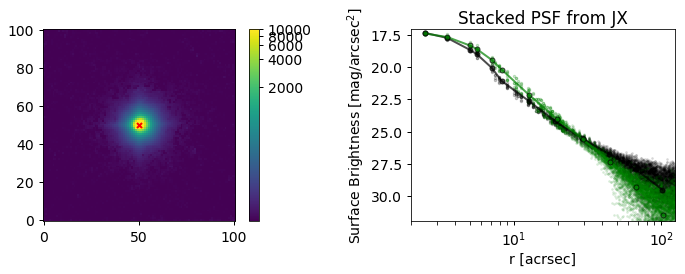

In [39]:
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="arcsec", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
I_stack_scale = Intensity2SB(z_rbin[np.argmin(abs(r_rbin-25))], mu, ZP, pix_scale)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="arcsec", yunit="SB", color="g",
                                             scatter=True, core_undersample=True)
I_stack_scale_p = Intensity2SB(z_rbin[np.argmin(abs(r_rbin-25))], mu, ZP, pix_scale)

plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

In [11]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(df_SE_target))]

r = np.logspace(0.03,2.5,100)

def recover_fit_PSF(params, r=r, mags=[15,12,9]):
    
    print("Fit results: ", params)

    # PSF Parameters
    n_fit = params[1]                     # true power index
    f_fit = 10**params[0]                 # fraction of power law component
    theta_t = 5.
    theta_t_pix = theta_t / pix_scale 

    beta_psf = 10
    fwhm = 2.28 * pix_scale                         # moffat fwhm, in arcsec

    gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
    gamma_pix = gamma / pix_scale  

    c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
    c_pow2Dto1D = C_pow2Dto1D(n_fit, theta_t_pix)

    I_mags = [10**((mag-ZP)/-2.5) for mag in mags]
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D 
    comp2 = trunc_power1d_normed(r, n_fit, theta_t_pix) / c_pow2Dto1D

    I_tot_s = [Intensity2SB(((1-f_fit) * comp1 + comp2 * f_fit) * I, 0, ZP, pix_scale)
                                      for I in I_mags]
    return I_tot_s

In [25]:
def plot_fit_data(fit_res, df_SE_target, table_res_Rnorm, res_thumb, use_norm='mean', c_fit='r'):
    pmed, pmean, pcov = get_params_fit(fit_res)
    I_tot_15, I_tot_12, I_tot_9 = recover_fit_PSF(pmed)
    
    z_norm_s, sky_mean_s = table_res_Rnorm['mean'], table_res_Rnorm['sky']
    mu_local = np.median(sky_mean_s)
    
    fig,ax = plt.subplots(figsize=(8,7))
    ax.set_prop_cycle(plt.cycler('color', plt.cm.viridis_r(np.linspace(0, 0.9, len(z_norm_s)))))
    for num, rmag, z_m, sky_m in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], z_norm_s, sky_mean_s):
        alpha = min(0.1*(16-rmag), 0.7) 
#         plt.plot(10, Intensity2SB(z_m, mu_local, ZP, pix_scale),"*", ms=5, color="gold", alpha=alpha, zorder=3)
        res = res_thumb[num]
        img, ma, bkg, cen = res["image"], res["mask"], res["bkg"], res["center"]
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                     ZP=ZP, sky_mean=mu_local, sky_std=std,
                                                     xunit="pix", yunit="SB", color=None, 
                                                     lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=9.5, x2=10.5, color="gray", alpha=0.3)

    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                                 ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                                 xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                                 core_undersample=True)
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                                 ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                                 xunit="pix", yunit="SB", color="m", lw=4, label="Stacked PSF patch (JX)",
                                                 core_undersample=True)
    for k, I in enumerate([I_tot_9, I_tot_12, I_tot_15]):
        lab = "Fit (R = 9/12/15 mag)" if k==0 else None
        plt.plot(r, I, color=c_fit, ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
        
    B_1sigma = Intensity2SB(pmed[3], 0, ZP, pix_scale)
    B_hsigma = Intensity2SB(pmed[3]/2., 0, ZP, pix_scale)
    plt.axhline(B_1sigma, color="k", ls=":", zorder=0, alpha=0.8)
    plt.axhline(B_hsigma, color="k", ls=":", lw=1, zorder=0, alpha=0.8)
    plt.text(1, B_1sigma-0.2, r"1 $\sigma$",fontsize=12)
    plt.text(1, B_hsigma+0.5, r"1/2 $\sigma$",fontsize=12)
    plt.legend(fontsize=14)
    plt.ylim(32,16.)
    plt.xlim(0.9,220)

In [37]:
def plot_fit_data_rescale(fit_res, df_SE_target, table_res_Rnorm, res_thumb, 
                          n_bright=25, use_norm='mean', c_fit='r'):
    pmed, _, _ = get_params_fit(fit_res)
    I_fit = recover_fit_PSF(pmed, mags=[9])[0]
    I_fit_norm = I_fit[np.argmin(abs(r-10))]
    
    norm = table_res_Rnorm[use_norm]
    df_SE_target['R_norm'] = norm
    
    df_target_b = df_SE_target.sort_values('R_norm', ascending=False).iloc[:n_bright]
    table_res_Rnorm_b = table_res_Rnorm[np.argsort(norm)[::-1]][:n_bright]
    z_norm_s, sky_mean_s = table_res_Rnorm_b[use_norm], table_res_Rnorm_b['sky']
    mu_local = np.median(sky_mean_s)
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax.set_prop_cycle(plt.cycler('color', plt.cm.viridis_r(np.linspace(0, 0.9, n_bright))))
    for num, rmag, z_m, sky_m in zip(df_target_b["NUMBER"], df_target_b["RMAG_AUTO"], z_norm_s, sky_mean_s):
        alpha = min(0.2*(16-rmag), 0.5) 
        I_scale = Intensity2SB(z_m, mu_local, ZP, pix_scale)
        res = res_thumb[num]
        img, ma, bkg, cen = res["image"], res["mask"], res["bkg"], res["center"]
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                      ZP=ZP, sky_mean=mu_local, sky_std=std,
                                                      xunit="arcsec", yunit="SB", color=None, 
                                                      lw=2, markersize=3, alpha=alpha,
                                                      I_shift=(I_fit_norm-I_scale))
        
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                                 ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                                 xunit="arcsec", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                                 core_undersample=True,I_shift=(I_fit_norm-I_stack_scale))
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                                 ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                                 xunit="arcsec", yunit="SB", color="m", lw=4, label="Stacked PSF patch (JX)",
                                                 core_undersample=True,I_shift=(I_fit_norm-I_stack_scale_p))

    plt.plot(r*2.5, I_fit, color=c_fit, ls="--", lw=3, zorder=3, alpha=0.9)
    plt.fill_betweenx([32, 15.], x1=9.5*2.5, x2=10.5*2.5, color="gray", edgecolor=None, alpha=0.3)
    B_1sigma = Intensity2SB(pmed[3], 0, ZP, pix_scale)
    B_hsigma = Intensity2SB(pmed[3]/2., 0, ZP, pix_scale)
    plt.axhline(B_1sigma, color="k", ls=":", zorder=0, alpha=0.8)
    plt.axhline(B_hsigma, color="k", ls=":", lw=1, zorder=0, alpha=0.8)
    plt.text(6, B_1sigma-0.2, r"1 $\sigma$",fontsize=12)
    plt.text(6, B_hsigma+0.5, r"1/2 $\sigma$",fontsize=12)
    plt.ylim(30.5,15.5)
    plt.xlim(5,510)

    # dummy image
    mag_min, mag_max = df_target_b["RMAG_AUTO"].min(), df_target_b["RMAG_AUTO"].max()
    im = ax.imshow([[0,0]], aspect="auto", cmap="viridis_r", 
                   vmin=10, vmax=13, alpha=0.8)
    im.set_visible(False)
    cax = fig.add_axes([0.68, 0.8, 0.18, 0.02])
    cb = plt.colorbar(im, cax=cax, ticks=np.linspace(10,13,6), orientation='horizontal')
    cb.ax.tick_params(labelsize=8)
    cb.set_label(r"$\tt{RMAG\_AUTO}$", labelpad=6, fontsize=12)
    cb.ax.xaxis.set_label_position('top')

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [14]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
res_thumb1 = load_thumbs('Thumb_15mag_X800Y1800')
table_res_Rnorm1 = Table.read("./Rnorm_10pix_15mag_X800Y1800.txt", format="ascii")

Read thumbs from: Thumb_15mag_X800Y1800


In [16]:
df_SE_target1 = df_SE_target.copy()

Fit results:  [-5.12795580e-01  3.56096025e+00  8.84061328e+02  2.69475208e+00]


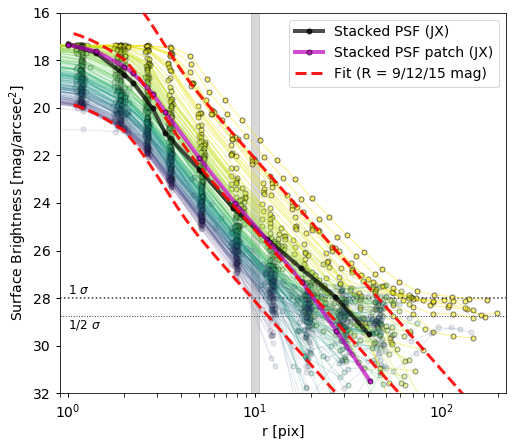

In [26]:
plot_fit_data(fit_res1, df_SE_target1, table_res_Rnorm1, res_thumb1, c_fit="r")

Fit results:  [-5.12868806e-01  3.56091981e+00  8.84061328e+02  2.69473744e+00]


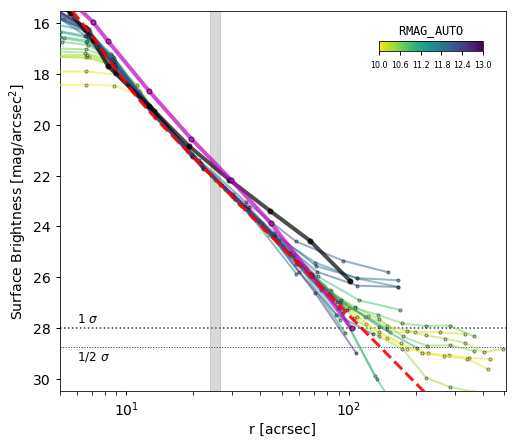

In [40]:
plot_fit_data_rescale(fit_res1, df_SE_target1, table_res_Rnorm1, res_thumb1, n_bright=25)

Interpolation

In [180]:
n_bright = 5
df_target_bright = df_SE_target.reindex(np.argsort(res_Rnorm[:,0])[::-1]).iloc[:n_bright]

res_Rnorm_bright = res_Rnorm[np.argsort(res_Rnorm[:,0])[::-1]][:n_bright]
z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm_bright.T

bins = np.logspace(0.3,2.5,21)
r_bins = np.logspace(0.3,2.2,20)
I_bins = np.empty((len(res_Rnorm_bright), len(r_bins)))

for k, (num, rmag, sky_m) in enumerate(zip(df_target_bright["NUMBER"],df_target_bright["RMAG_AUTO"],sky_mean_s)):
    img, ma, cen = img_s[num], ma_s[num], cen_s[num]
    alpha = min(0.1*(16-rmag), 0.7) 
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                  bins=np.logspace(0,2.5,20),
                                                  ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                  xunit="pix", yunit="SB", draw=False,
                                                  color=c, lw=1, alpha=alpha)
    
    f_intp = interp1d(r_rbin[~np.isnan(z_rbin)], Intensity2SB(z_rbin[~np.isnan(z_rbin)], sky_m, ZP, pix_scale), "cubic")
    I_bins[k] = f_intp(r_bins)
    
plt.figure(figsize=(8,7))

for k, (I, z_m, sky_m) in enumerate(zip(I_bins, z_mean_s, sky_mean_s)):
    norm = Intensity2SB(z_m, sky_m, ZP, pix_scale)
    plt.plot(r_bins, I-(norm-22.2), lw=3, alpha=0.5)

plt.plot(r, I_tot_9, color="r", ls="--", lw=3, label=lab, zorder=3, alpha=0.9)

# plt.fill_betweenx([0, 32.], x1=0, x2=24, color="gray", alpha=0.1)

plt.xlabel("r [pix]")
plt.ylabel("Surface Brightness [mag/arcsec$^2$]")        
plt.ylim(30,16.)
plt.xlim(2,150)
plt.xscale("log")

Is Background Gaussian?

1406.0294433209683 1409.8058098394959 112.33212891100392


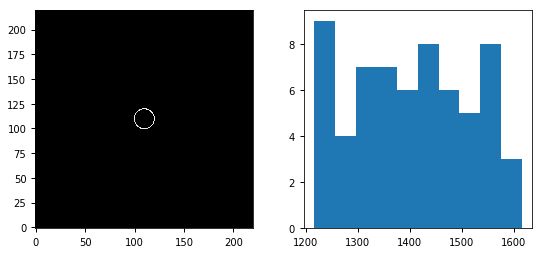

In [252]:
img, ma, back, cen = extract_star(17420, SE_cat_full, display_bg=False, display=False)
z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=10, wid=0.5, display=True)
print(z_mean, z_med, z_std)

885.6840662138387 885.4099377741663 3.09253640591153


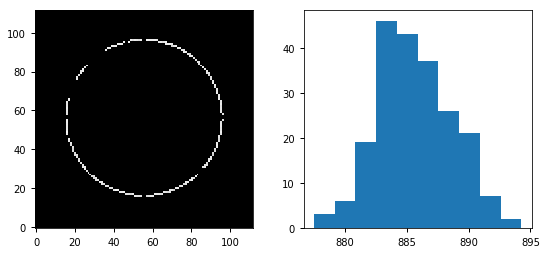

In [316]:
img, ma, back, cen = extract_star(11470, SE_cat_full, n_win=20, display_bg=False, display=False)
z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=40, wid=0.5, mask_cross=True, display=True)
print(z_mean, z_med, z_std)

In [320]:
np.sqrt((0.1/0.434*(z_med-np.median(back)))**2 + 3**2)

3.0000003513658227

In [318]:
0.434 * z_std/abs(z_med-np.median(back))

212.9901038990813

In [257]:
0.434 * z_std/(z_med-np.median(back))

0.1000212630497735

In [293]:
(z_med-np.median(back))/0.434*0.1

0.4252722308255507

### Patch [3100, 1400, 4100, 2400] stars < 15 mag

In [275]:
fit_res2 = open_nested_fitting_result(filename='./real/fit_real_best_X3100Y1400.res')
res_thumb2 = load_thumbs('Thumb_15mag_X3100Y1400')
table_res_Rnorm2 = Table.read("./Rnorm_10pix_15mag_X3100Y1400.txt", format="ascii")

Read thumbs from: Thumb_15mag_X3100Y1400


Fit results:  [-6.50509899e-01  3.37575899e+00  8.86088256e+02  2.99074463e+00]


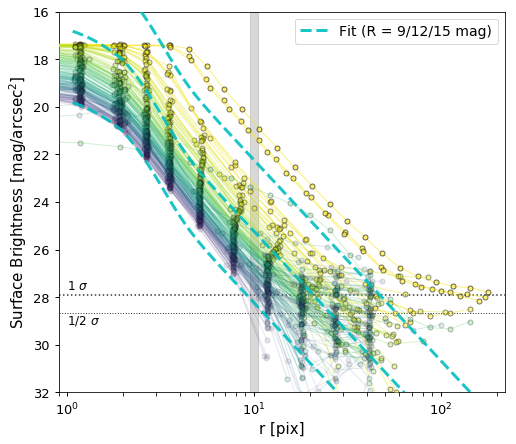

In [514]:
plot_fit_data(fit_res2, df_SE_target2, table_res_Rnorm2, res_thumb2, c_fit="c")
plt.savefig("Plots/PatchB.pdf")

Fit results:  [-6.50516705e-01  3.37575963e+00  8.86088256e+02  2.99072388e+00]


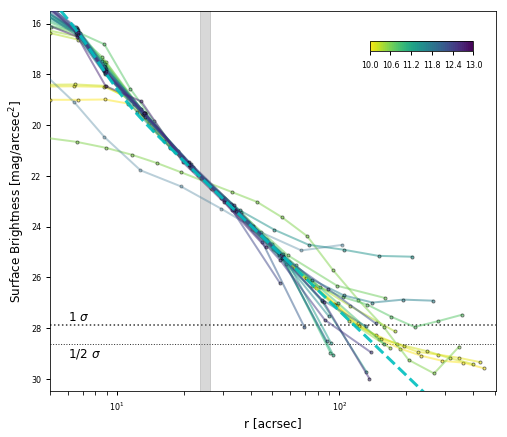

In [283]:
plot_fit_data_rescale(fit_res2, df_SE_target2, table_res_Rnorm2, res_thumb2, c_fit="c", n_bright=25)

### Another patch [800, 600, 1800, 1600]  containing brighter stars

In [540]:
fit_res2 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y600.res')

Fit results:  [-7.53655162e-01  3.37091777e+00  8.86120470e+02  3.44796765e+00]


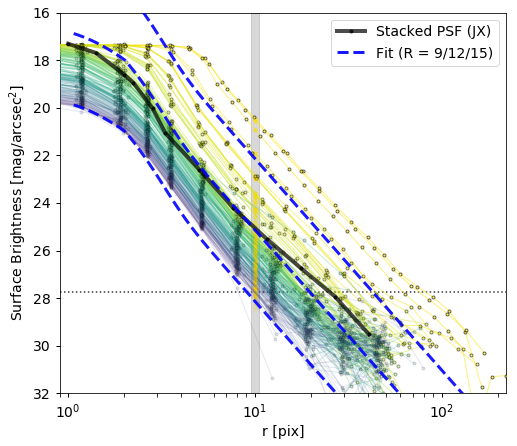

In [600]:
plot_fit_data(fit_res2, df_SE_target, res_Rnorm, c_fit="c")

Fit results:  [-7.53674241e-01  3.37091777e+00  8.86120569e+02  3.44800822e+00]


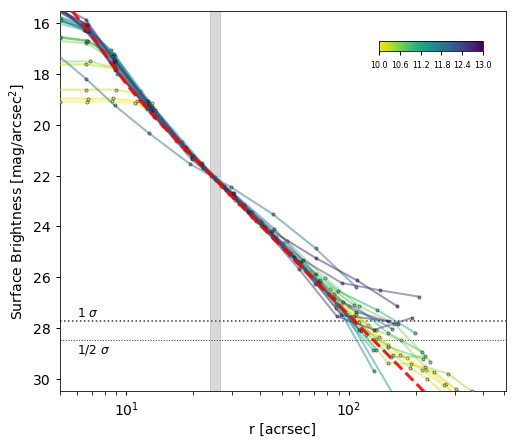

In [592]:
plot_fit_data_rescale(fit_res2, df_SE_target, res_Rnorm, n_bright=25)

### Plot Posterior

In [60]:
image_bounds1 = (800, 1800, 1800, 2800)
image_bounds2 = (3100, 1400, 4100, 2400)
        
patch1, seg_patch1 = crop_image(data, seg_map, image_bounds1, weight_map=weight_edge, 
                                sky_mean=mu, sky_std=std, color="w",draw=False)
patch2, seg_patch2 = crop_image(data, seg_map, image_bounds2, weight_map=weight_edge, 
                                sky_mean=mu, sky_std=std, color="w",draw=False)

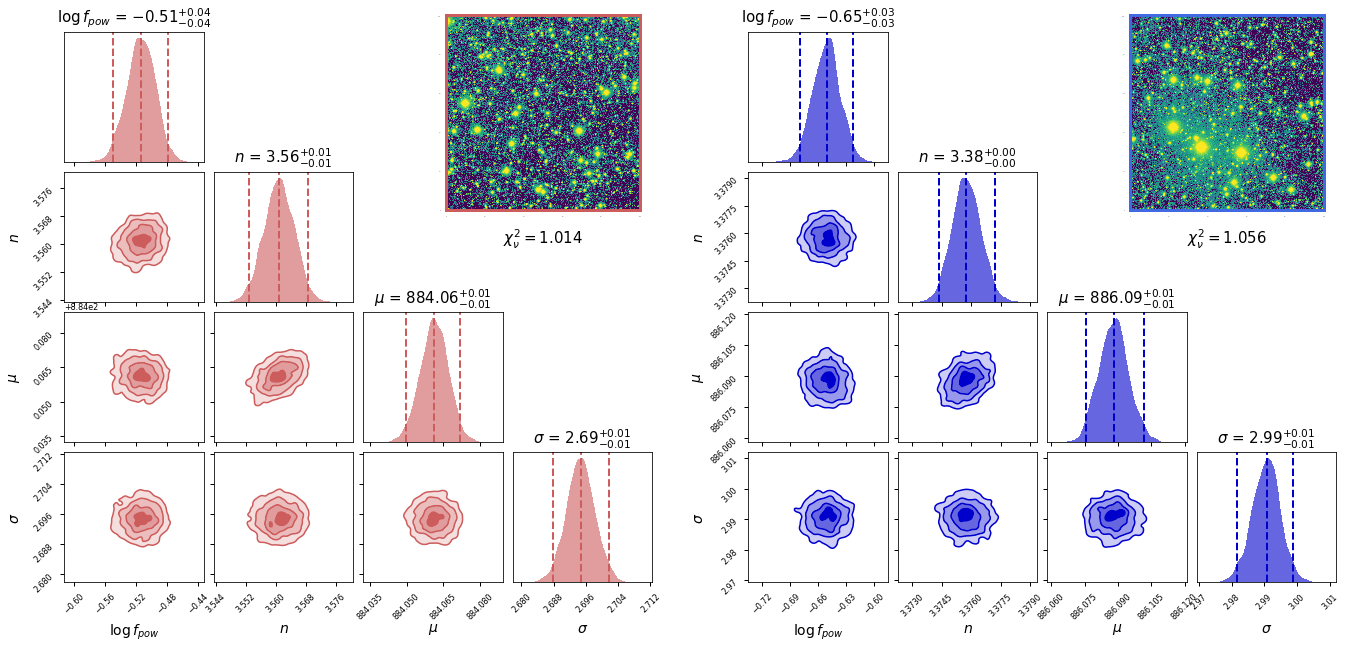

In [462]:
fig, axes = plt.subplots(figsize=(19, 9))
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(4, 4)
gs1.update(top=0.95, bottom=0.1, left=0.05, right=0.48, wspace=0.07, hspace=0.075)
axes1 = np.array([plt.subplot(gs1[i, j]) for i in range(4) for j in range(4)]).reshape(4,4)

gs2 = gridspec.GridSpec(4, 4)
gs2.update(top=0.95, bottom=0.1, left=0.55, right=0.98, wspace=0.07, hspace=0.075)
axes2 = np.array([plt.subplot(gs2[i, j]) for i in range(4) for j in range(4)]).reshape(4,4)

ax_ins1 = fig.add_axes([0.325,0.675,0.15,0.3])
ax_ins2 = fig.add_axes([0.825,0.675,0.15,0.3])
for ax, p, c, chi2 in zip([ax_ins1, ax_ins2],[patch1,patch2],['indianred','royalblue'],[1.014,1.056]):
    ax.imshow(p, origin="lower", norm=norm1, vmin=mu, vmax=1e3)
    ax.tick_params(axis='both', labelsize=0, length=0)    
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(3)
    plt.text(0.5, -0.15, r'$\chi_\nu^2=%.3f$'%chi2, fontsize=15, ha='center', va='center', transform=ax.transAxes)

from dynesty import plotting as dyplot
labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
fig1, axes1 = dyplot.cornerplot(fit_res1, show_titles=True, 
                                  color="indianred", labels=labels,
                                  title_kwargs={'fontsize':15, 'y': 1.02}, 
                                  label_kwargs={'fontsize':14},
                                  fig=(fig, axes1))
fig2, axes2 = dyplot.cornerplot(fit_res2, show_titles=True, 
                                  color="mediumblue", labels=labels,
                                  title_kwargs={'fontsize':15, 'y': 1.02}, 
                                  label_kwargs={'fontsize':14},
                                  fig=(fig, axes2))
plt.savefig("Plots/Corner_Plot.pdf")

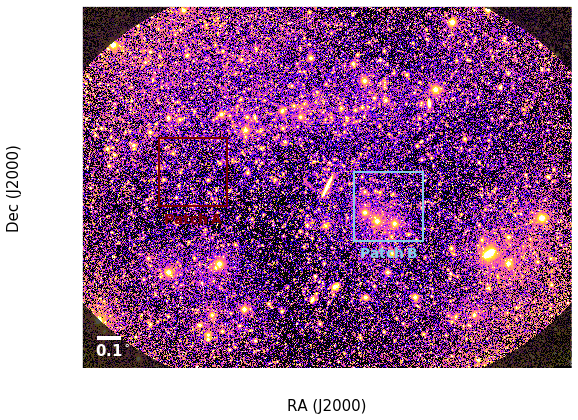

In [540]:
# with plt.rc_context({'axes.edgecolor':'w', 'xtick.color':'w', 'ytick.color':'w','figure.facecolor':'None'}):
    fig = plt.figure(figsize=(8,6)) 
    ax = plt.subplot(projection=wcs_data)
    plt.imshow(data, vmin=mu, vmax=1e3, norm=norm1, origin="lower", cmap="gnuplot2",alpha=0.95)
    if weight_edge is not None:
        plt.imshow(data*weight_edge, vmin=mu, vmax=1e3, norm=norm1, origin="lower", cmap="gnuplot2",alpha=0.7)
    plt.plot([2800-2600,3040-2600],[350,350],"w", lw=4)
    plt.text(2960-2600,150, r"$\bf 0.1^\circ$", color='w', ha='center', fontsize=15)

    rect1a = patches.Rectangle((800+100,1800+100), 800, 800,
                              linewidth=2, linestyle="-", edgecolor="", facecolor='none')
    rect2a = patches.Rectangle((3100+100,1400+100), 800, 800,
                              linewidth=2, linestyle="-", edgecolor="skyblue", facecolor='none')
    for rect in [rect1a, rect2a]:
        ax.add_patch(rect)

    ax.text(1300, 1700, r"$\bf Patch\,A$", color="",fontsize=14, ha='center')
    ax.text(3600, 1300, r"$\bf Patch\,B$", color="skyblue",fontsize=14, ha='center')

    plt.xlabel("RA (J2000)")
    plt.ylabel("Dec (J2000)")
    plt.subplots_adjust(bottom=0.1,top=0.95,left=0.1,right=0.95)
    plt.savefig("Plots/DF_Field.pdf", transparent=True)

In [493]:
def plot_fit_data_rescale_ax(fit_res, df_SE_target, table_res_Rnorm, res_thumb, 
                          n_bright=25, use_norm='mean', c_fit='r', caxes=None):
    pmed, _, _ = get_params_fit(fit_res)
    I_fit = recover_fit_PSF(pmed, mags=[9])[0]
    I_fit_norm = I_fit[np.argmin(abs(r-10))]
    norm = table_res_Rnorm[use_norm]
    df_SE_target['R_norm'] = norm
    
    df_target_b = df_SE_target.sort_values('R_norm', ascending=False).iloc[:n_bright]
    table_res_Rnorm_b = table_res_Rnorm[np.argsort(norm)[::-1]][:n_bright]
    z_norm_s, sky_mean_s = table_res_Rnorm_b[use_norm], table_res_Rnorm_b['sky']
    mu_local = np.median(sky_mean_s)

    ax.set_prop_cycle(plt.cycler('color', plt.cm.viridis_r(np.linspace(0, 0.9, n_bright))))
    for num, rmag, z_m, sky_m in zip(df_target_b["NUMBER"], df_target_b["RMAG_AUTO"], z_norm_s, sky_mean_s):
        alpha = min(0.2*(16-rmag), 0.5) 
        I_scale = Intensity2SB(z_m, mu_local, ZP, pix_scale)
        res = res_thumb[num]
        img, ma, bkg, cen = res["image"], res["mask"], res["bkg"], res["center"]
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                      ZP=ZP, sky_mean=mu_local, sky_std=std,
                                                      xunit="arcsec", yunit="SB", color=None, 
                                                      lw=2, markersize=3, alpha=alpha,
                                                      I_shift=(I_fit_norm-I_scale))
    plt.plot(r*2.5, I_fit, color=c_fit, ls="--", lw=3, zorder=3, alpha=0.9)
    plt.fill_betweenx([32, 15.], x1=9.5*2.5, x2=10.5*2.5, color="orange", edgecolor=None, alpha=0.3)
    plt.plot(10*2.5, I_fit_norm,"*", ms=20, mfc="orange", mec="k",alpha=0.95, zorder=5)
    plt.ylim(29.5,15.5)
    plt.xlim(5,450)

    # dummy image
    mag_min, mag_max = df_target_b["RMAG_AUTO"].min(), df_target_b["RMAG_AUTO"].max()
    im = ax.imshow([[0,0]], aspect="auto", cmap="viridis_r", 
                   vmin=10, vmax=13, alpha=0.8)
    im.set_visible(False)
    cax = fig.add_axes(caxes)
    cb = plt.colorbar(im, cax=cax, ticks=np.linspace(10,13,4), orientation='horizontal')
    cb.ax.tick_params(labelsize=8)
    cb.set_label(r"$\tt{RMAG\_AUTO}$", labelpad=7, fontsize=14)
    cb.ax.xaxis.set_label_position('top')

Fit results:  [-5.12792608e-01  3.56094792e+00  8.84061316e+02  2.69476948e+00]
Fit results:  [-6.50516705e-01  3.37576102e+00  8.86088256e+02  2.99072812e+00]


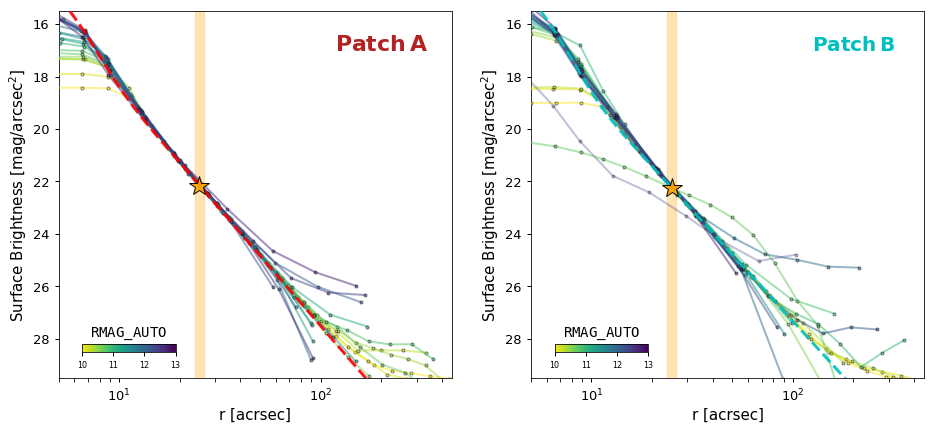

In [495]:
fig = plt.figure(figsize=(13,6))
ax=plt.subplot(121)
plot_fit_data_rescale_ax(fit_res1, df_SE_target1, table_res_Rnorm1, res_thumb1, c_fit="r", n_bright=20,
                        caxes=[0.075, 0.16, 0.1, 0.02])
ax.text(200, 17, r"$\bf Patch\,A$", color="firebrick",fontsize=22, ha='center')
ax=plt.subplot(122)
plot_fit_data_rescale_ax(fit_res2, df_SE_target2, table_res_Rnorm2, res_thumb2, c_fit="c", n_bright=20,
                        caxes=[0.58, 0.16, 0.1, 0.02])
ax.text(200, 17, r"$\bf Patch\,B$", color="c",fontsize=20, ha='center')
plt.subplots_adjust(bottom=0.1,top=0.95,left=0.05,right=0.975, hspace=0.2, wspace=0.2)
plt.savefig("Plots/Fit1D.pdf")

### Overplot on literature

#### Sandin 2014

In [218]:
import pandas as pd
PSF_S14 = pd.read_csv("./web_digit/wpd_Sandin2014.csv", skiprows=1)
PSF_A14 = pd.read_csv("./web_digit/A14b.csv")
PSF_S14

,X0,Y0,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6
0,0.368067,-0.535191,0.418671,-0.615773,0.346719,-1.100553,1.532212,-2.474939,0.394881,-1.151837,0.325427,-1.090290,5.246585,-3.262648
1,0.455611,-0.597518,0.657181,-0.787656,0.422437,-1.105402,1.829596,-2.658433,0.480363,-1.175316,0.399466,-1.100270,6.055071,-3.427220
2,0.556899,-0.686049,0.852677,-1.031655,0.518562,-1.130538,2.184696,-2.841557,0.582687,-1.196488,0.490352,-1.113280,6.944268,-3.570640
3,0.695388,-0.834256,1.194843,-1.302185,0.636544,-1.142790,2.608731,-3.027459,0.723847,-1.224997,0.601924,-1.132353,7.711390,-3.685169
4,0.818370,-0.995381,1.533520,-1.560494,0.781409,-1.181566,3.057550,-3.211672,0.883790,-1.251614,0.738903,-1.165824,8.531188,-3.851578
5,0.935613,-1.170024,2.155610,-2.060543,0.959260,-1.228678,3.517414,-3.393740,1.110676,-1.307040,0.907078,-1.212178,10.317539,-4.151088
6,1.053199,-1.358887,2.380136,-2.196645,1.177659,-1.305345,4.046439,-3.575212,1.363931,-1.357467,1.113587,-1.284298,11.532407,-4.356366
7,1.156486,-1.553661,3.025839,-2.651144,1.445879,-1.416113,4.569102,-3.757634,1.647380,-1.433141,1.367207,-1.392792,12.806297,-4.545787
8,1.258130,-1.750547,3.639871,-3.031839,1.758875,-1.569960,5.111520,-3.949016,2.031762,-1.518247,1.663167,-1.544485,15.775841,-4.965781
9,1.356007,-1.944128,4.007072,-3.342906,2.061349,-1.721858,5.771973,-4.150492,2.509828,-1.655835,1.967460,-1.705061,13.801424,-4.697589


Fit results:  [-5.12746408e-01  3.56093182e+00  8.84061299e+02  2.69476221e+00]
Fit results:  [-6.50613155e-01  3.37576102e+00  8.86088265e+02  2.99074877e+00]


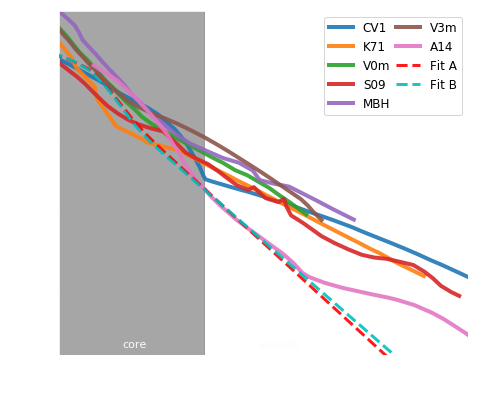

In [528]:
pmed, _, _ = get_params_fit(fit_res1)
I_fit1 = recover_fit_PSF(pmed, mags=[4.5])[0]
pmed, _, _ = get_params_fit(fit_res2)
I_fit2 = recover_fit_PSF(pmed, mags=[4.5])[0]
I_n = 0

labels = ["CV1", "K71", "V0m", "S09", r"MBH", "V3m", 'A14']
# with plt.rc_context({'axes.edgecolor':'w', 'xtick.color':'w', 'axes.labelcolor':'w', 'ytick.color':'w','figure.facecolor':'None'}):

plt.figure(figsize=(7,6))
for k, lab in enumerate(labels):
    x, y = PSF_S14["X%d"%k], PSF_S14["Y%d"%k]
    y_sort = -2.5*y.reindex(np.argsort(x)) + 2.5 * np.log10(pix_scale**2)
    x_sort = x.reindex(np.argsort(x))
    plt.semilogx(x_sort,y_sort, lw=4, alpha=0.9, label=lab)

plt.semilogx(r*2.5, I_fit1-I_n, color="r", ls="--", lw=3, label="Fit A", zorder=3, alpha=0.9)
plt.semilogx(r*2.5, I_fit2-I_n, color="c", ls="--", lw=3, label="Fit B", zorder=3, alpha=0.9)

# plt.axhline(I_tot_12.min()+15-I_n,color="k",ls="--")
plt.legend(ncol=2, fontsize=12, columnspacing=0.5, framealpha=0.8)
plt.fill_betweenx([0, 32.], x1=0, x2=30, color="gray", alpha=0.7)
plt.text(10,29,"core", ha='center', fontsize=11,color="snow")
plt.text(100,29,"aureole", ha='center', fontsize=11,color="snow")
plt.xlabel("r [arcsec]")
plt.ylabel("Surface Brightness [mag/arcsec$^2$]")        
plt.ylim(29.5, 6.5)
plt.xlim(3, 2000)
plt.tight_layout()
